# Optimization of the simply supported beam

## Import libraries and modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torch import optim

from NN_library.SPD_CNN_modular import *
from utilities.dataset import *
from utilities.save_load import *
from utilities.FEM_2d_elasticity import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using device: cuda


## Load data and the network

In [3]:
# Initialize the dataset
data = dataset_opt()

# Load the network: 'dev' - CPU or CUDA device, 'train_mode' - to obtain K_grid or C_grid, here we only need the K_grid
args = {'dev' : dev, 'name' : 'NN_library/NN_10x10_[1, 3]', 'train_mode' : 'stiffness'}
network = SPD_CNN(res=20, kernels=[1, 3], train_mode=args['train_mode'], input=2) # change the res parameter according to the size of the beam
network = load_network(network, args['name'], args)
network = network.to(dev)
for p in network.parameters():
    p.requires_grad_ = False
network.eval()

SPD_CNN(
  (conv_blocks): ModuleList(
    (0): Conv_block(
      (c11): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1))
      (c12): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (c13): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Conv_block(
      (c11): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (c12): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (c13): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (FNN_blocks): ModuleList(
    (0): SPD_Block(
      (convt): ConvTranspose2d(32, 1, kernel_size=(1, 36), stride=(1, 36), bias=False)
    )
    (1): SPD_Block(
      (convt): ConvTranspose2d(64, 1, kernel_size=(1, 528), stride=(1, 528), bias=False)
    )
  )
)

## Optimize the simply supported beam

In [4]:
batch = 32

# load the data sample, 0: 6x6, 2: 10x10, 4: 20x20
layout, support, force, zero_map, DBC, f = data.__getitem__(4)
layout = layout.repeat(batch, 1, 1, 1).to(dev)
f = f.to(dev).repeat(batch, 1, 1)
zero_map = zero_map.repeat(batch, 1, 1)
DBC = DBC.repeat(batch, 1, 1).to(dev)

# Normalize the displacement with a uniformly built structure
K = network(2*layout, zero_map, DBC, f)
_, u_max = find_deform(K+DBC, f)

In [2]:
# Calculate global density
def find_rho(layout, res=8):
    n = torch.where(layout[:,0]!=0, 1, 0).sum(dim=(-2, -1))
    M = (2*res*layout[:,0] + 2*(res-2*layout[:,0])*layout[:,1]) / (res*res)
    rho = M.sum(dim=(-2, -1)) / n
    return rho

# Conversion between one-hot and numerical encoding
def convert(input, layout):
    x, y = torch.meshgrid(torch.arange(1, 5), torch.arange(1, 5), indexing='ij')
    xy = torch.vstack([x.flatten(), y.flatten()]).to(device=dev)
    output_one_hot = F.gumbel_softmax(input, tau=1, hard=True, eps=1e-10, dim=1)
    output_x_num = (output_one_hot * xy[0].view(1,16,1,1)).sum(dim=1, keepdim=True)
    output_y_num = (output_one_hot * xy[1].view(1,16,1,1)).sum(dim=1, keepdim=True)
    output_xy = torch.cat([output_x_num, output_y_num], dim=1)
    output_clean = output_xy * layout[:, [0]].detach()
    return output_clean

In [5]:
# initialize the log-probabilities
x_0 = torch.zeros(batch, 16, layout.shape[-2], layout.shape[-1]).to(dev)
x_0.requires_grad_()

# initialize the list to collect the cost function values
us = []
penalty = []
outputs = []
loss = []

In [6]:
optimizer = optim.Adam([x_0], lr = 0.1, maximize=False)

In [13]:
args['penalty'] = 10.
idx = np.arange(layout.shape[-1]//2)[::-1].tolist()
for i in range(200):
    # Convert the log-probabilities to a layout with Gumbel-max
    y = convert(x_0, layout)
    # Fix the structure to be symmetric
    y[:,:,:,layout.shape[-1]//2:] = y[:,:,:,idx]
    # Estimate the global stiffness matrix
    K = network(y, zero_map, DBC, f)
    # Solve the Ku = f
    _, u = find_deform(K+DBC, f)
    # Find the average cost function
    rho = find_rho(y)
    p = args['penalty'] * torch.relu(rho-0.75)
    u_norm = u/u_max.detach()
    l = (u_norm + p).mean()
    # Optimizer step
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    # Save individual values of the cost function
    loss.append(l.detach().cpu())
    us.append(u_norm.detach().cpu())
    penalty.append(p.detach().cpu())
    outputs.append(y.detach().cpu())

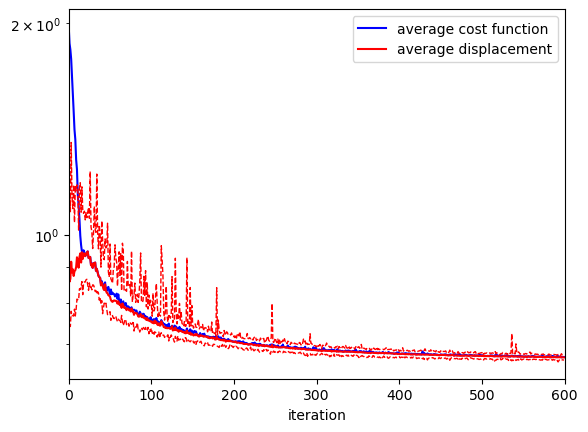

In [14]:
plt.plot(np.array(loss), c='b')
plt.plot(np.array(us).mean(axis=1), c='r')
plt.plot(np.array(penalty).mean(axis=1), c='g')
plt.plot(np.array(us).min(axis=1), '--r', linewidth=1)
plt.plot(np.array(us).max(axis=1), '--r', linewidth=1)
plt.xlabel('iteration')
plt.xlim([0, len(loss)])
plt.legend(['average cost function', 'average displacement', 'average penalty'])
plt.yscale('log')

## Print the results

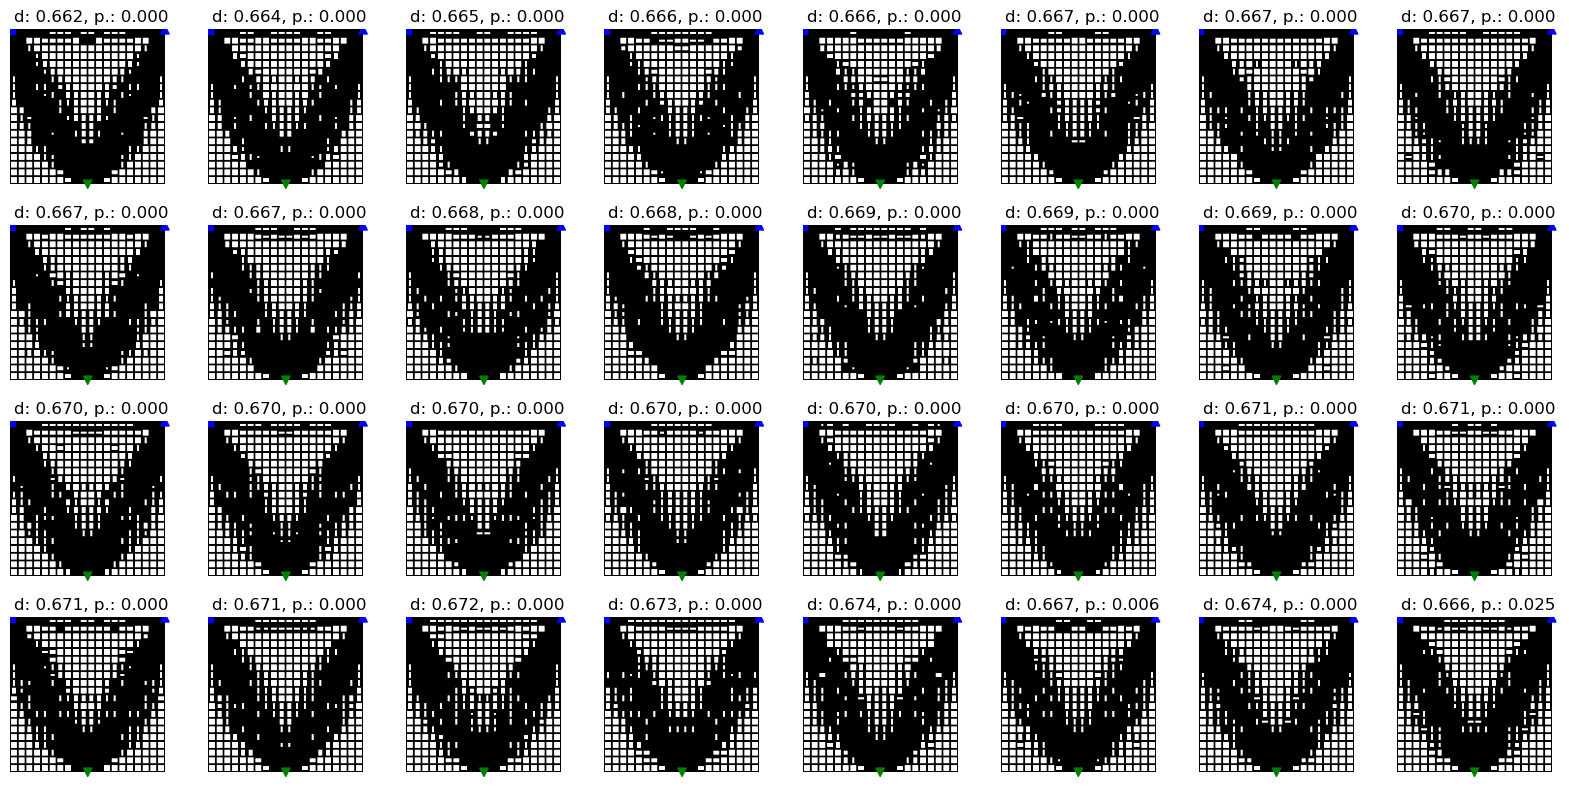

In [15]:
x_g, y_g = np.meshgrid(np.linspace(0, layout.shape[-2]*8, layout.shape[-2]+1), np.linspace(0, layout.shape[-1]*8, layout.shape[-1]+1))
fig, axs = plt.subplots(batch//8, 8, figsize=(2*8, 2*batch//8))
best_idx = torch.argsort(us[-1]+penalty[-1])
for j in range(batch):
    i = best_idx[j].item()
    img = create_image_from_layout(outputs[-1][i])
    axs.flat[j].imshow(img, cmap='Greys_r')
    axs.flat[j].scatter(x_g, y_g, c='b', marker='s', alpha=support[0].detach().cpu())
    axs.flat[j].scatter(x_g, y_g, c='b', marker='^', alpha=support[1].detach().cpu())
    axs.flat[j].scatter(x_g, y_g, c='g', marker='>', alpha=force[0].detach().cpu())
    axs.flat[j].scatter(x_g, y_g, c='g', marker='v', alpha=force[1].detach().cpu())
    axs.flat[j].set_title(f'd: {us[-1][i]:.3f}, p.: {penalty[-1][i]:.3f}')
    axs.flat[j].axis('off')
plt.tight_layout()

## Verify the results with FEA

In [16]:
# Define the domain
coarse_grid = (layout.shape[-2], layout.shape[-1])
res = 8
coarse_x, coarse_y = np.meshgrid(np.arange(coarse_grid[0]+1), np.arange(coarse_grid[1]+1))
coarse_coordinates = np.vstack([coarse_x.flatten(), coarse_y.flatten()]).T
x, y = np.meshgrid(np.linspace(0, coarse_grid[0], coarse_grid[0]*res+1), np.linspace(0, coarse_grid[1], coarse_grid[1]*res+1))
x = x.flatten()
y = y.flatten()
glob_numbering = np.reshape(np.arange(len(x)), (coarse_grid[0]*res+1, coarse_grid[1]*res+1))
coarse_idx = glob_numbering[0::res,0::res].flatten()

# Create DNS module stiffness matrices
K_module = {}
K_module[(0, 0)] = create_module_domain(1, 0, 0.3, 0, 0, res)
for i in range(1, res//2 + 1):   
    for j in range(1, res//2 + 1):
        K_module[(i, j)] = create_module_domain(1, 0, 0.3, i, j, res)

# Define boundary conditions
support_coarse = [0, 1, 2*coarse_grid[0]+1]
support_hd = 2 * coarse_idx[np.array(support_coarse) // 2] + (np.array(support_coarse) % 2)
force_idx = np.vstack([2*coarse_idx, 2*coarse_idx+1]).T.flatten()
coarse_with_BC_idx = np.setdiff1d(force_idx, support_hd, assume_unique=False)
row_mask = np.isin(force_idx, coarse_with_BC_idx)
mask = np.outer(row_mask, row_mask)
F_glob = np.zeros((2*len(x), 1))
F_glob[force_idx] = f[0].detach().cpu()
f_idx = np.argwhere(f[0].detach().cpu().numpy())[0,0]

In [18]:
# verify the final batch with FEA
u_real = []
for n in range(batch):
    K_glob = assemble_global_stiffness(K_module, outputs[-1][n].detach().cpu().numpy().reshape(2, -1).T, coarse_grid, len(x), res)
    K_ff, F_f, dof = apply_BCs(K_glob, F_glob, support_hd)
    U_ff = np.linalg.solve(K_ff.astype(np.float32), F_f.astype(np.float32))
    U_glob = np.zeros((2*len(x), 1))
    U_glob[dof] = U_ff
    u_real.append(U_glob[force_idx][f_idx])

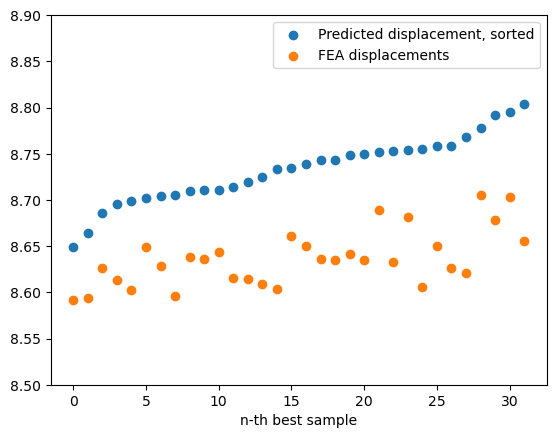

In [24]:
sorted = np.argsort(us[-1])
plt.scatter(np.arange(batch), us[-1][sorted]*u_max[0].item())
plt.scatter(np.arange(batch), np.array(u_real)[sorted])
plt.xlabel('n-th best sample')
plt.legend(['Predicted displacement, sorted', 'FEA displacements'])

In [ ]:
u_real = np.array(u_real).flatten()
sorted = np.argsort(u_real)
u_NN = np.array(us[-1] * u_max[0].item())
plt.figure(figsize=[7.5, 5])
plt.plot(u_real[sorted], np.zeros(batch), 'b--*')
plt.scatter(u_real[sorted], (u_NN[sorted]-u_real[sorted]) / u_real[sorted], c='r', s=6)
plt.vlines(u_real[sorted], np.zeros(batch), (u_NN[sorted]-u_real[sorted]) / u_real[sorted], color='r', linestyles='dashed', lw=1)
plt.legend(['FEA displacement', 'NN prediction'])
plt.xlabel('Displacement, FEA')
plt.ylabel('Relative error')
plt.grid()